# An Introduction to Adversarial Attacks using Foolbox



# Set Up Kaggle API and download dataset

Kaggle, a subsidiary of Google LLC, is an online community of data scientists and machine learning practitioners. Kaggle is host to a number of competitions and a plethora of dataset. Using a API from kaggle, datasets can directly be downloaded into colab. For our purpose we will be using a cats and dogs dataset available in Kaggle. Also we will mount google drive for convenience

In [ ]:
!pip install -q kaggle
!gdown --id 1wObfz33pLg8oSVbz8kOMS7zepsFw71kE

Downloading...
From: https://drive.google.com/uc?id=1wObfz33pLg8oSVbz8kOMS7zepsFw71kE
To: /content/kaggle.json
100% 70.0/70.0 [00:00<00:00, 113kB/s]


In [ ]:
from IPython.display import clear_output
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tongpython/cat-and-dog
!mkdir cat-and-dog
!unzip cat-and-dog.zip -d cat-and-dog
clear_output(wait=False)

In [ ]:
# #mounting google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!gdown --id 1OSF0P_P1vtBz5iHh0k0YBu4sGlnJ7oAU

Downloading...
From: https://drive.google.com/uc?id=1OSF0P_P1vtBz5iHh0k0YBu4sGlnJ7oAU
To: /content/utils.py
100% 1.62k/1.62k [00:00<00:00, 3.13MB/s]


In [ ]:
!pip install tensorflow==2.1.0
!pip install numpy == 1.18.1
!pip install h5py==2.10.0
clear_output(wait=False)

# Import Necessary Libraries

In our notebook we will be using the tensorflow Keras API. Keras is a deep learning API written in Python, running on top of the machine learning platform TensorFlow. Tensorflow is an open source library developed by google. It is a symbolic math library, and is also used for machine learning applications such as neural networks.
We will also use the library openCV for preprocessing and loading the images, matplotlib to display images and numpy for dealing with matrices.

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as L
from tensorflow.keras.models import load_model
from utils import loss_plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = 250

In [ ]:
tf.__version__

'2.1.0'

Let us start by checking out the structure of the dataset and also view a few images in the training set

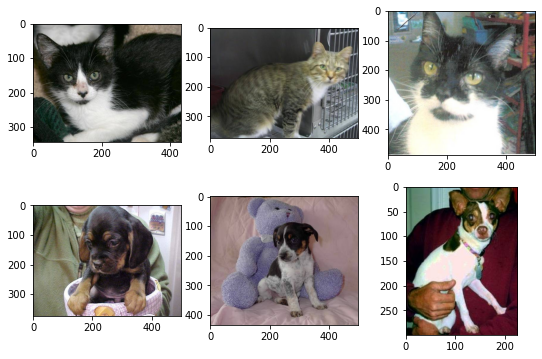

In [ ]:
plt.figure(figsize=(9,6))
for id, img in enumerate(os.listdir('/content/cat-and-dog/training_set/training_set/cats/')[4:7]):
  img = cv2.imread('/content/cat-and-dog/training_set/training_set/cats/'+img)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  plt.subplot(2,3,id+1)
  plt.imshow(img)
for id, img in enumerate(os.listdir('/content/cat-and-dog/training_set/training_set/dogs/')[5:8]):
  img = cv2.imread('/content/cat-and-dog/training_set/training_set/dogs/'+img)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  plt.subplot(2,3,id+4)
  plt.imshow(img)

In [ ]:
len_train_set = len(os.listdir('/content/cat-and-dog/training_set/training_set/dogs/'))+len(os.listdir('/content/cat-and-dog/training_set/training_set/cats/'))
len_test_set = len(os.listdir('/content/cat-and-dog/test_set/test_set/dogs/'))+len(os.listdir('/content/cat-and-dog/test_set/test_set/cats/'))

In [ ]:
print(f'length of test set:{len_test_set}')
print(f'length of training set:{len_train_set}')

length of test set:2025
length of training set:8007


# Design a Simple Classifier

Before we discuss what is transfer learning and how it may be used, let us first build a baseline model that would enable us to better understand the benifits of transfer learning. We wil build a simple model with a few [convolutional](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/), [max pooling](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) and [dense layers](https://www.tutorialspoint.com/keras/keras_dense_layer.htm)

The following is an animation of how convolutional layer works in general. We see a kernel is convolved with the input image to generate a feature map. In simpler words the filter is slid across the width and height of the input and the dot products between the input and filter are computed at every spatial position. The weights of the filter need to be learned during training

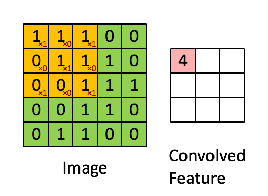

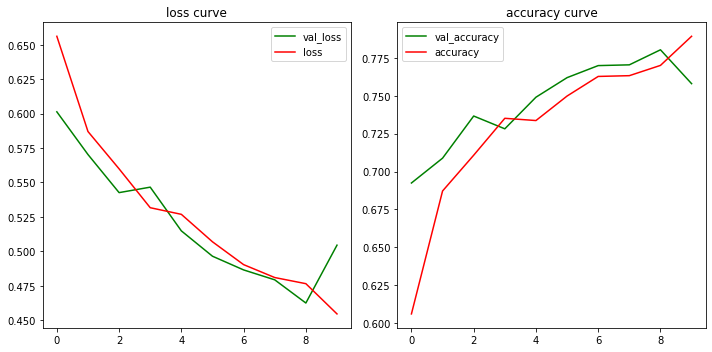

epoch 10/50 loss: 0.455 accuracy: 0.7892 val_loss: 0.504 val_accuracy:0.7579
250/250 [==============================] - 122s 489ms/step - loss: 0.4535 - accuracy: 0.7892 - val_loss: 0.5044 - val_accuracy: 0.7579
[INFO] Best Validation Accuracy:  0.78025794


In [ ]:
# Initialising the CNN
classifier = tf.keras.models.Sequential()

# Step 1 - Convolution
classifier.add(L.Convolution2D(32, 3, 3, input_shape = (IMG_SIZE, IMG_SIZE, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(L.MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional block
classifier.add(L.Convolution2D(32, 3, 3, activation = 'relu'))
classifier.add(L.MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(L.Flatten())

# Step 4 - Full connection
classifier.add(L.Dense(128, activation = 'relu'))
classifier.add(L.Dense(2, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Part 2 - Fitting the CNN to the images

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('/content/cat-and-dog/training_set/training_set',
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/cat-and-dog/test_set/test_set',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            batch_size = 32,
                                            class_mode = 'categorical')
chckpt_path = 'model.CNN.hdf5'
loss_plot = loss_plt()

chckpt  = tf.keras.callbacks.ModelCheckpoint(chckpt_path, save_best_only=True,monitor = 'val_accuracy',mode='max')
classifier.fit_generator(training_set,
                         steps_per_epoch = len_train_set//32,
                         epochs = 10,
                         validation_data = test_set,
                         validation_steps = len_test_set//32,
                         callbacks=[chckpt, loss_plot]
                         )

In [ ]:
model = load_model('model.CNN.hdf5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 83, 83, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               147584    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

# Building a better model: Transfer Learning Using Inception V3

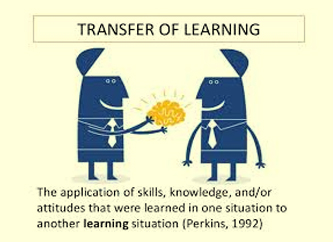

In [ ]:
train_datagen = ImageDataGenerator(shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   preprocessing_function = tf.keras.applications.inception_v3.preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_v3.preprocess_input)
training_set = train_datagen.flow_from_directory('/content/cat-and-dog/training_set/training_set',
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/cat-and-dog/test_set/test_set',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


## About Inception Model

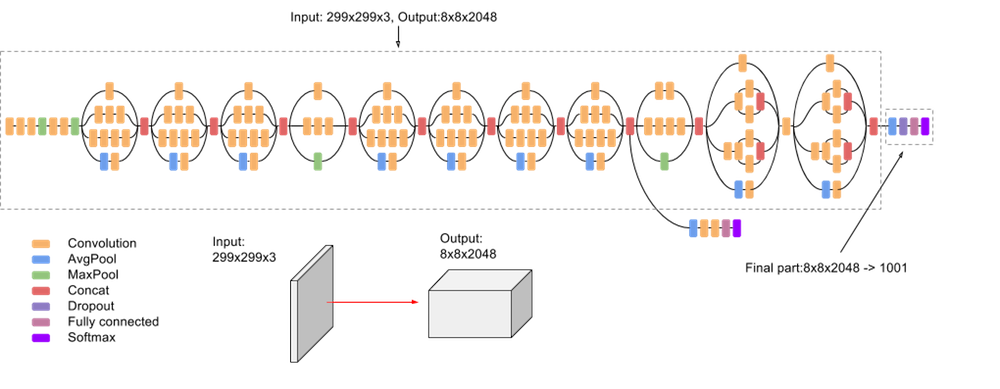

Inception V3 is a very complex network architecture developed by google. This network consists of what are known as inception blocks. These are basically blocks of 3x3 and 1x1 convolutional layers that are stacked in a way as seen in the above layout.

In [ ]:
def Inception():
    model=tf.keras.applications.InceptionV3(include_top=False,weights='imagenet',input_shape=(250,250,3))
    
    new_output= L.GlobalAveragePooling2D()(model.output)
    new_output = L.Dense(4,activation="relu")(new_output)
    new_output=L.Dense(2,activation='softmax')(new_output)
    model= tf.keras.Model(inputs = model.inputs,outputs = new_output)
    
    return model

In [ ]:
model = Inception()

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in model.layers:
    layer.trainable=True
    
    if isinstance(layer,L.BatchNormalization):
        layer.momentum=0.9
for layer in model.layers[:-50]:
    if not isinstance(layer,L.BatchNormalization):
        layer.trainable=False

In [ ]:
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
             metrics=['accuracy'])

In [ ]:
ch_path = 'model.best.hdf5'
chckpt = tf.keras.callbacks.ModelCheckpoint(ch_path, save_best_only=True, monitor='val_accuracy', mode='max')
loss_plot = loss_plt()

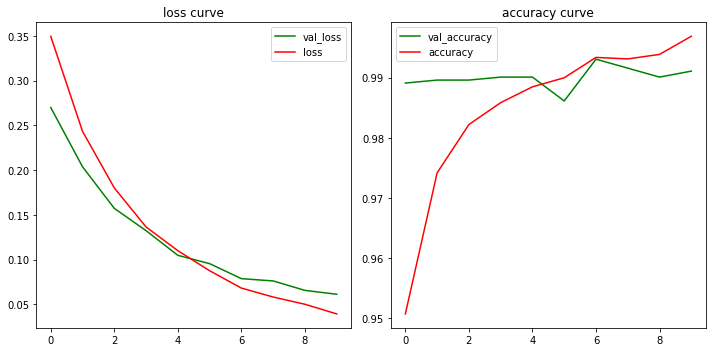

epoch 10/50 loss: 0.039 accuracy: 0.9969 val_loss: 0.061 val_accuracy:0.9911
250/250 [==============================] - 152s 606ms/step - loss: 0.0392 - accuracy: 0.9969 - val_loss: 0.0612 - val_accuracy: 0.9911
[INFO] Best Validation Accuracy:  0.9930556


In [ ]:
model.fit_generator(training_set,
                    steps_per_epoch = len_train_set//32,
                    epochs = 10,
                    validation_data = test_set,
                    validation_steps = len_test_set//32,
                    callbacks=[chckpt, loss_plot]
                    )

In [ ]:
# !cp "model.CNN.hdf5" "/content/gdrive/MyDrive/func_files/"
# !cp "model.best.hdf5" "/content/gdrive/MyDrive/func_files/"
# drive.flush_and_unmount()

# Let's See The Performance

In [ ]:
from PIL import Image

In [ ]:
!gdown --id 1dGSgM7JFmquK5xdOJ4TuKxB2Idq3UusG
!gdown --id 16a65brs5fr8RQk-MceCRrMPf7_ERh9lY

Downloading...
From: https://drive.google.com/uc?id=1dGSgM7JFmquK5xdOJ4TuKxB2Idq3UusG
To: /content/model.CNN.hdf5
100% 1.94M/1.94M [00:00<00:00, 89.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=16a65brs5fr8RQk-MceCRrMPf7_ERh9lY
To: /content/model.best.hdf5
100% 139M/139M [00:00<00:00, 166MB/s]


In [ ]:
inception = load_model('model.best.hdf5')
cnn = load_model("model.CNN.hdf5")

In [ ]:
def util_predict(prob_cnn, prob_inc):
  ret_string = ""
  label_cnn = np.argmax(prob_cnn,axis=-1)
  label_inc = np.argmax(prob_inc,axis=-1)
  if label_cnn==1:
    ret_string += 'CNN: Dog({:.3f})\n'.format(prob_cnn[0][1])
  else:
    ret_string += 'CNN: Cat({:.3f})\n'.format(prob_cnn[0][0])
  
  if label_inc==1:
    ret_string += 'Inception: Dog({:.3f})'.format(prob_inc[0][1])
  else:
    ret_string += 'Inception: Cat({:.3f})'.format(prob_inc[0][0])
  return ret_string

In [ ]:
%sx wget -c "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg" -O 'cat0.jpg'
%sx wget -c "https://d3544la1u8djza.cloudfront.net/APHI/Blog/2016/10_October/persians/Persian+Cat+Facts+History+Personality+and+Care+_+ASPCA+Pet+Health+Insurance+_+white+Persian+cat+resting+on+a+brown+sofa-min.jpg" -O 'cat1.jpg'
%sx wget -c "https://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/article_thumbnails/other/cat_relaxing_on_patio_other/1800x1200_cat_relaxing_on_patio_other.jpg" -O 'cat2.jpg'
%sx wget -c "https://post.medicalnewstoday.com/wp-content/uploads/sites/3/2020/02/322868_1100-1100x628.jpg" -O 'dog0.jpg'
%sx wget -c "https://i.insider.com/5484d9d1eab8ea3017b17e29?width=1100&format=jpeg&auto=webp" -O 'dog1.jpg'
%sx wget -c "https://scx2.b-cdn.net/gfx/news/hires/2018/2-dog.jpg" -O 'dog2.jpg'

['--2022-02-08 05:59:09--  https://scx2.b-cdn.net/gfx/news/hires/2018/2-dog.jpg',
 'Resolving scx2.b-cdn.net (scx2.b-cdn.net)... 185.93.1.243',
 'Connecting to scx2.b-cdn.net (scx2.b-cdn.net)|185.93.1.243|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 415118 (405K) [image/jpeg]',
 'Saving to: ‘dog2.jpg’',
 '',
 '',
 'dog2.jpg              0%[                    ]       0  --.-KB/s               ',
 'dog2.jpg            100%[===================>] 405.39K  --.-KB/s    in 0.04s   ',
 '',
 '2022-02-08 05:59:09 (9.34 MB/s) - ‘dog2.jpg’ saved [415118/415118]',
 '']

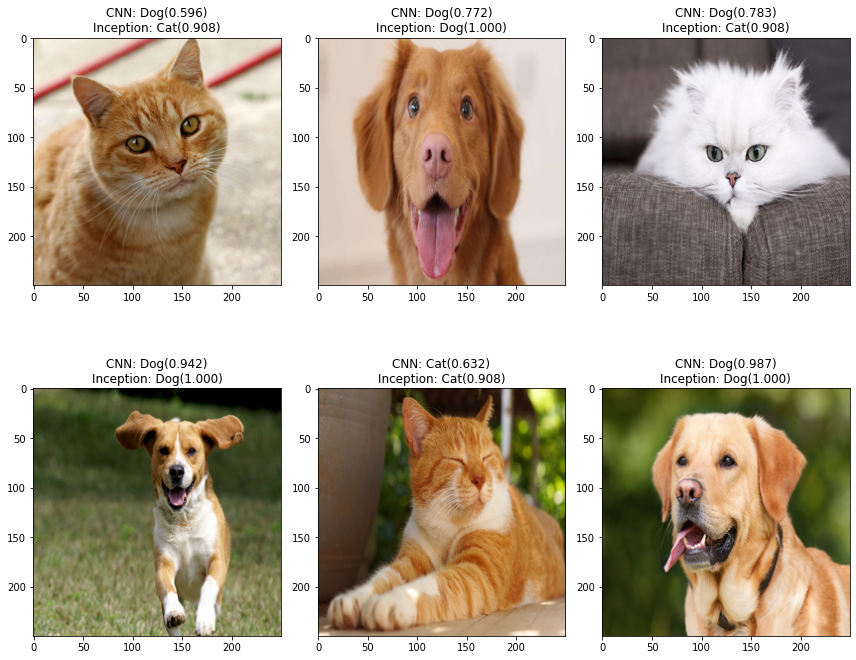

In [ ]:
images = ['cat0.jpg','dog0.jpg','cat1.jpg','dog1.jpg','cat2.jpg','dog2.jpg']
fig,ax = plt.subplots(2,3, figsize=(12,10))
ax = ax.flatten()
for idx,img in enumerate(images):
  img = np.asarray(Image.open(img).resize((IMG_SIZE,IMG_SIZE)))
  ax[idx].imshow(img)
  p_img = tf.keras.applications.inception_v3.preprocess_input(img)
  ax[idx].set_title(util_predict(cnn.predict(np.stack([img/255],axis=0)), inception.predict(np.stack([p_img],axis=0))))
plt.tight_layout()
plt.show()

# Adversarial Attacks: What? Why? How?

#### Adversarial machine learning is a field of machine learning that is concerned with the robustness of machine learning systems. Adverserial attacks are certain methods that aim to fool machine learning models. An adversarial attack involves introducing some perturbations in the inputs in order to cause the model to give incorrect outputs. 
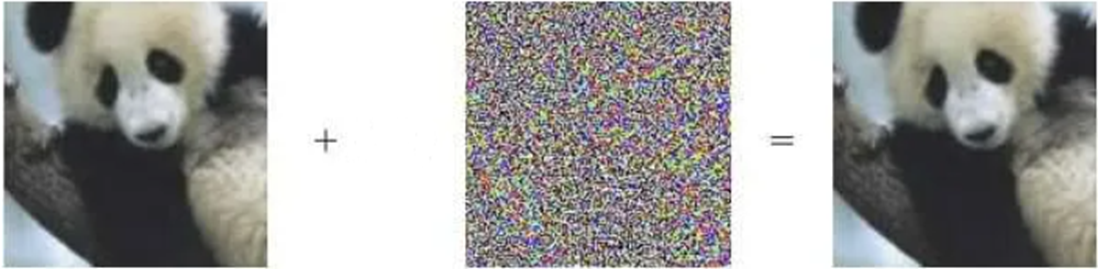

#### Adversarial attacks can be broadly categorised into White Box attacks and Black Box attacks. In white box attacks the adversary has complete knowledge of the target model and may also have access to the training data. In black box adversarial attacks adversary has limited knowledge of the model (such as architecture) but definitely does not know about the model parameters. In this notebook we will explore a few methods for white box adversarial attacks

#### To perform advererial attacks we will use a python library named "foolbox". Foolbox provides a framework for performing a wide array of adversarial attacks for popular deep learning frameworks such as Tensorflow, PyTorch, JAX etc.

In [ ]:
from IPython.display import clear_output
!pip install -q foolbox
!pip install -q eagerpy
clear_output(wait=False)

In [ ]:
!gdown --id 1dGSgM7JFmquK5xdOJ4TuKxB2Idq3UusG
!gdown --id 16a65brs5fr8RQk-MceCRrMPf7_ERh9lY

Downloading...
From: https://drive.google.com/uc?id=1dGSgM7JFmquK5xdOJ4TuKxB2Idq3UusG
To: /content/model.CNN.hdf5
100% 1.94M/1.94M [00:00<00:00, 112MB/s]
Downloading...
From: https://drive.google.com/uc?id=16a65brs5fr8RQk-MceCRrMPf7_ERh9lY
To: /content/model.best.hdf5
100% 139M/139M [00:01<00:00, 80.3MB/s]


In [ ]:
import eagerpy as ep
import foolbox
from foolbox import TensorFlowModel
from foolbox.attacks import FGSM
from foolbox.criteria import Misclassification
from PIL import Image

import glob
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as L
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = 250

#### We will use a test dataset that has never been seen before by the classifiers trained above.

In [ ]:
!kaggle datasets download -d chetankv/dogs-cats-images
!mkdir test_data
!unzip dogs-cats-images.zip -d test_data
clear_output(wait=False)

In [ ]:
images = []
labels = []
for f in glob.glob(os.path.join("/content/test_data/dataset/test_set/cats/","*.jpg"))[:10]:
  images.append(np.asarray(Image.open(f).resize((IMG_SIZE,IMG_SIZE)))/255)
  labels.append(0)
for f in glob.glob(os.path.join("/content/test_data/dataset/test_set/dogs/","*.jpg"))[:10]:
  images.append(np.asarray(Image.open(f).resize((IMG_SIZE,IMG_SIZE)))/255)
  labels.append(1)  
images = tf.constant(np.stack(images,axis=0))
labels = tf.constant(np.stack(labels,axis=0))

 ## FGSM attack: Fast Gradient Sign Method
 #### First we will attack the simple CNN classifier and observe the effects as the perturbations are gradually increased

In [ ]:
model = load_model("model.CNN.hdf5")
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
             metrics=['accuracy'])

In [ ]:
fmodel = TensorFlowModel(model, bounds=(0, 255))

In [ ]:
print("Initial Model Accuracy:",foolbox.utils.accuracy(fmodel, images, labels))

Initial Model Accuracy: 0.800000011920929


In [ ]:
attack = foolbox.attacks.FGSM()
epsilon = np.linspace(0.0, 0.01, num=20)
raw, clipped, is_adv = attack(fmodel , images, Misclassification(labels), epsilons=epsilon)

  Epsilon ≤ 0.000000: 80.0 %
  Epsilon ≤ 0.000526: 75.0 %
  Epsilon ≤ 0.001053: 65.0 %
  Epsilon ≤ 0.001579: 60.0 %
  Epsilon ≤ 0.002105: 50.0 %
  Epsilon ≤ 0.002632: 40.0 %
  Epsilon ≤ 0.003158: 25.0 %
  Epsilon ≤ 0.003684: 15.0 %
  Epsilon ≤ 0.004211: 15.0 %
  Epsilon ≤ 0.004737: 10.0 %
  Epsilon ≤ 0.005263: 10.0 %
  Epsilon ≤ 0.005789: 10.0 %
  Epsilon ≤ 0.006316:  5.0 %
  Epsilon ≤ 0.006842:  0.0 %


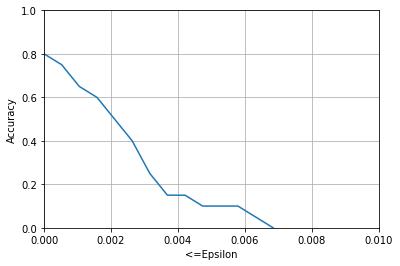

In [ ]:
epsilons, accuracy = [],[]
for eps, advs_ in zip(np.linspace(0.0, 0.01, num=20), clipped):
  acc2 = foolbox.utils.accuracy(fmodel, advs_, labels)
  epsilons.append(eps)
  accuracy.append(acc2)
  print(f"  Epsilon ≤ {eps:.6f}: {acc2 * 100:4.1f} %")
  if acc2 == 0:
      break
plt.figure()
plt.plot(epsilons,accuracy)
plt.grid()
plt.xlim(0,0.01)
plt.ylim(0,1)
plt.xlabel("<=Epsilon")
plt.ylabel("Accuracy")
plt.show()

#### Let's visualize the predictions and the adversarial images as the epsilon value is increased gradually.

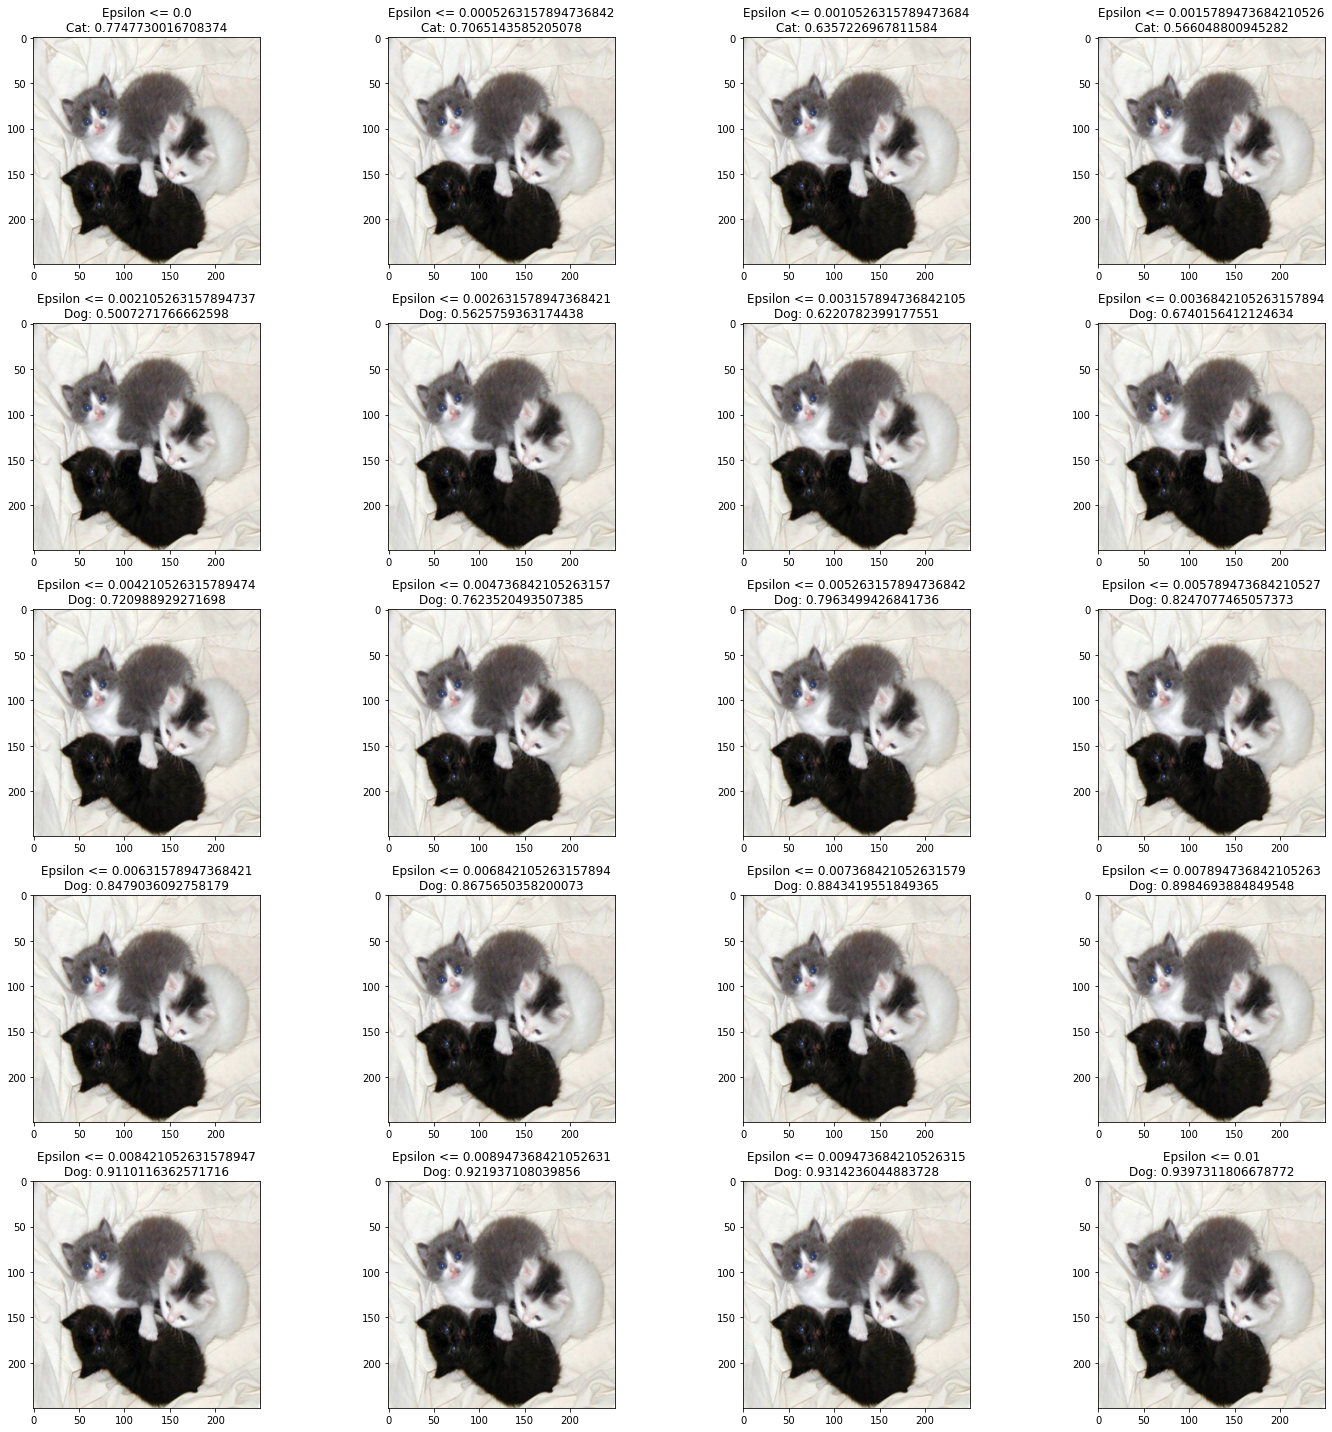

In [ ]:
fig,ax = plt.subplots(5,4,figsize=(20,20))
ax = ax.flatten()
for i in range(len(epsilon)):
  pred = model.predict(np.stack([clipped[i][0]],axis=0))
  label = ""
  if np.argmax(pred,axis=1):
    label = f"Dog: {pred[0,1]}"
  else:
    label = f"Cat: {pred[0,0]}"
  ax[i].imshow(clipped[i][0]);
  ax[i].set_title(f"Epsilon <= {epsilon[i]}\n"+label)
plt.tight_layout()
clear_output(wait=False)
plt.show()

#### While for lower values of epsilon the confidence of the model detoriates, once the epsilon values are large enough the model begins misclassifying the cat image as that of a dog. The confidence of the model while misclassifying this image gradually increases as epsilon increases.

### Now let's see the effect of a FGSM attack on the more accurate Inception model

In [ ]:
inception = load_model("model.best.hdf5")
inception.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
             metrics=['accuracy'])

In [ ]:
images_inc = []
labels_inc = []
for f in glob.glob(os.path.join("/content/test_data/dataset/test_set/cats/","*.jpg"))[:10]:
  images_inc.append(tf.keras.applications.inception_v3.preprocess_input(np.asarray(Image.open(f).resize((IMG_SIZE,IMG_SIZE)))))
  labels_inc.append(0)
for f in glob.glob(os.path.join("/content/test_data/dataset/test_set/dogs/","*.jpg"))[:10]:
  images_inc.append(tf.keras.applications.inception_v3.preprocess_input(np.asarray(Image.open(f).resize((IMG_SIZE,IMG_SIZE)))))
  labels_inc.append(1)  
images_inc = tf.constant(np.stack(images_inc,axis=0))
labels_inc = tf.constant(np.stack(labels_inc,axis=0))

In [ ]:
fmodel = TensorFlowModel(inception, bounds=(0, 255))
print("Initial Model Accuracy:",foolbox.utils.accuracy(fmodel, images_inc, labels_inc))

Initial Model Accuracy: 1.0


In [ ]:
attack = foolbox.attacks.FGSM()
epsilon = np.linspace(0.0, 0.01, num=20)
raw, clipped, is_adv = attack(fmodel , images_inc, Misclassification(labels_inc), epsilons=epsilon)

  Epsilon ≤ 0.000000: 100.0 %
  Epsilon ≤ 0.000526: 100.0 %
  Epsilon ≤ 0.001053: 100.0 %
  Epsilon ≤ 0.001579: 100.0 %
  Epsilon ≤ 0.002105: 100.0 %
  Epsilon ≤ 0.002632: 100.0 %
  Epsilon ≤ 0.003158: 100.0 %
  Epsilon ≤ 0.003684: 100.0 %
  Epsilon ≤ 0.004211: 100.0 %
  Epsilon ≤ 0.004737: 100.0 %
  Epsilon ≤ 0.005263: 100.0 %
  Epsilon ≤ 0.005789: 100.0 %
  Epsilon ≤ 0.006316: 100.0 %
  Epsilon ≤ 0.006842: 100.0 %
  Epsilon ≤ 0.007368: 100.0 %
  Epsilon ≤ 0.007895: 100.0 %
  Epsilon ≤ 0.008421: 100.0 %
  Epsilon ≤ 0.008947: 100.0 %
  Epsilon ≤ 0.009474: 95.0 %
  Epsilon ≤ 0.010000: 95.0 %


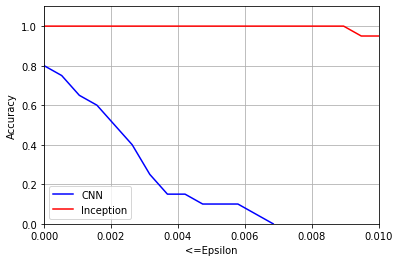

In [ ]:
inc_epsilons, inc_accuracy = [],[]
for eps, advs_ in zip(np.linspace(0.0, 0.01, num=20), clipped):
  acc2 = foolbox.utils.accuracy(fmodel, advs_, labels)
  inc_epsilons.append(eps)
  inc_accuracy.append(acc2)
  print(f"  Epsilon ≤ {eps:.6f}: {acc2 * 100:4.1f} %")
  if acc2 == 0:
      break
plt.figure()
plt.plot(epsilons,accuracy,label='CNN',color='blue')
plt.plot(inc_epsilons,inc_accuracy,label='Inception',color='red')

plt.grid()
plt.xlim(0,0.01)
plt.ylim(0,1.1)
plt.xlabel("<=Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### As observed here, the Inception model is extremely robust and impervious to FGSM attacks for small values of epslion. Only when the values of epsilon are significantly higher, we observe some effect (as shown below).

In [ ]:
attack = foolbox.attacks.FGSM()
epsilon = np.linspace(0.0, 0.5, num=20)
raw, clipped, is_adv = attack(fmodel , images, Misclassification(labels), epsilons=epsilon)
inc_epsilons, inc_accuracy = [],[]
for eps, advs_ in zip(np.linspace(0.0, 0.1, num=20), clipped):
  acc2 = foolbox.utils.accuracy(fmodel, advs_, labels)
  inc_epsilons.append(eps)
  inc_accuracy.append(acc2)
  print(f"  Epsilon ≤ {eps:.6f}: {acc2 * 100:4.1f} %")
  if acc2 == 0:
      break

  Epsilon ≤ 0.000000: 100.0 %
  Epsilon ≤ 0.005263: 65.0 %
  Epsilon ≤ 0.010526: 65.0 %
  Epsilon ≤ 0.015789: 75.0 %
  Epsilon ≤ 0.021053: 75.0 %
  Epsilon ≤ 0.026316: 80.0 %
  Epsilon ≤ 0.031579: 75.0 %
  Epsilon ≤ 0.036842: 65.0 %
  Epsilon ≤ 0.042105: 65.0 %
  Epsilon ≤ 0.047368: 65.0 %
  Epsilon ≤ 0.052632: 70.0 %
  Epsilon ≤ 0.057895: 70.0 %
  Epsilon ≤ 0.063158: 65.0 %
  Epsilon ≤ 0.068421: 60.0 %
  Epsilon ≤ 0.073684: 70.0 %
  Epsilon ≤ 0.078947: 70.0 %
  Epsilon ≤ 0.084211: 70.0 %
  Epsilon ≤ 0.089474: 80.0 %
  Epsilon ≤ 0.094737: 85.0 %
  Epsilon ≤ 0.100000: 85.0 %


## Carlini Wagner attack (C&W attack)

In [ ]:
model = load_model("model.CNN.hdf5")
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
             metrics=['accuracy'])
inception = load_model("model.best.hdf5")
inception.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
             metrics=['accuracy'])

In [ ]:
fmodel1 = TensorFlowModel(model, bounds=(0, 255))
fmodel2 = TensorFlowModel(inception, bounds=(0, 255))

In [ ]:
print("Initial Model Accuracy CNN:",foolbox.utils.accuracy(fmodel1, images, labels))
print("Initial Model Accuracy Inception:",foolbox.utils.accuracy(fmodel2, images_inc, labels_inc))

Initial Model Accuracy CNN: 0.800000011920929
Initial Model Accuracy Inception: 1.0


In [ ]:
%%time
attack = foolbox.attacks.L2CarliniWagnerAttack()
epsilon = np.linspace(0.0, 1, num=20)
raw, clipped, is_adv = attack(fmodel1 , tf.cast(images,tf.float32), Misclassification(labels), epsilons=epsilon)

CPU times: user 2min 57s, sys: 16 s, total: 3min 13s
Wall time: 3min 53s


In [ ]:
epsilons, accuracy = [],[]
for eps, advs_ in zip(np.linspace(0.0, 1, num=20), clipped):
  acc2 = foolbox.utils.accuracy(fmodel1, advs_, labels)
  epsilons.append(eps)
  accuracy.append(acc2)
  print(f"  Epsilon ≤ {eps:.6f}: {acc2 * 100:4.1f} %")
  if acc2 == 0:
      break

  Epsilon ≤ 0.000000: 80.0 %
  Epsilon ≤ 0.052632: 80.0 %
  Epsilon ≤ 0.105263: 75.0 %
  Epsilon ≤ 0.157895: 75.0 %
  Epsilon ≤ 0.210526: 75.0 %
  Epsilon ≤ 0.263158: 70.0 %
  Epsilon ≤ 0.315789: 65.0 %
  Epsilon ≤ 0.368421: 65.0 %
  Epsilon ≤ 0.421053: 65.0 %
  Epsilon ≤ 0.473684: 65.0 %
  Epsilon ≤ 0.526316: 65.0 %
  Epsilon ≤ 0.578947: 65.0 %
  Epsilon ≤ 0.631579: 60.0 %
  Epsilon ≤ 0.684211: 60.0 %
  Epsilon ≤ 0.736842: 55.0 %
  Epsilon ≤ 0.789474: 55.0 %
  Epsilon ≤ 0.842105: 50.0 %
  Epsilon ≤ 0.894737: 45.0 %
  Epsilon ≤ 0.947368: 35.0 %
  Epsilon ≤ 1.000000: 30.0 %


### Detoriation of Accuracy of CNN model

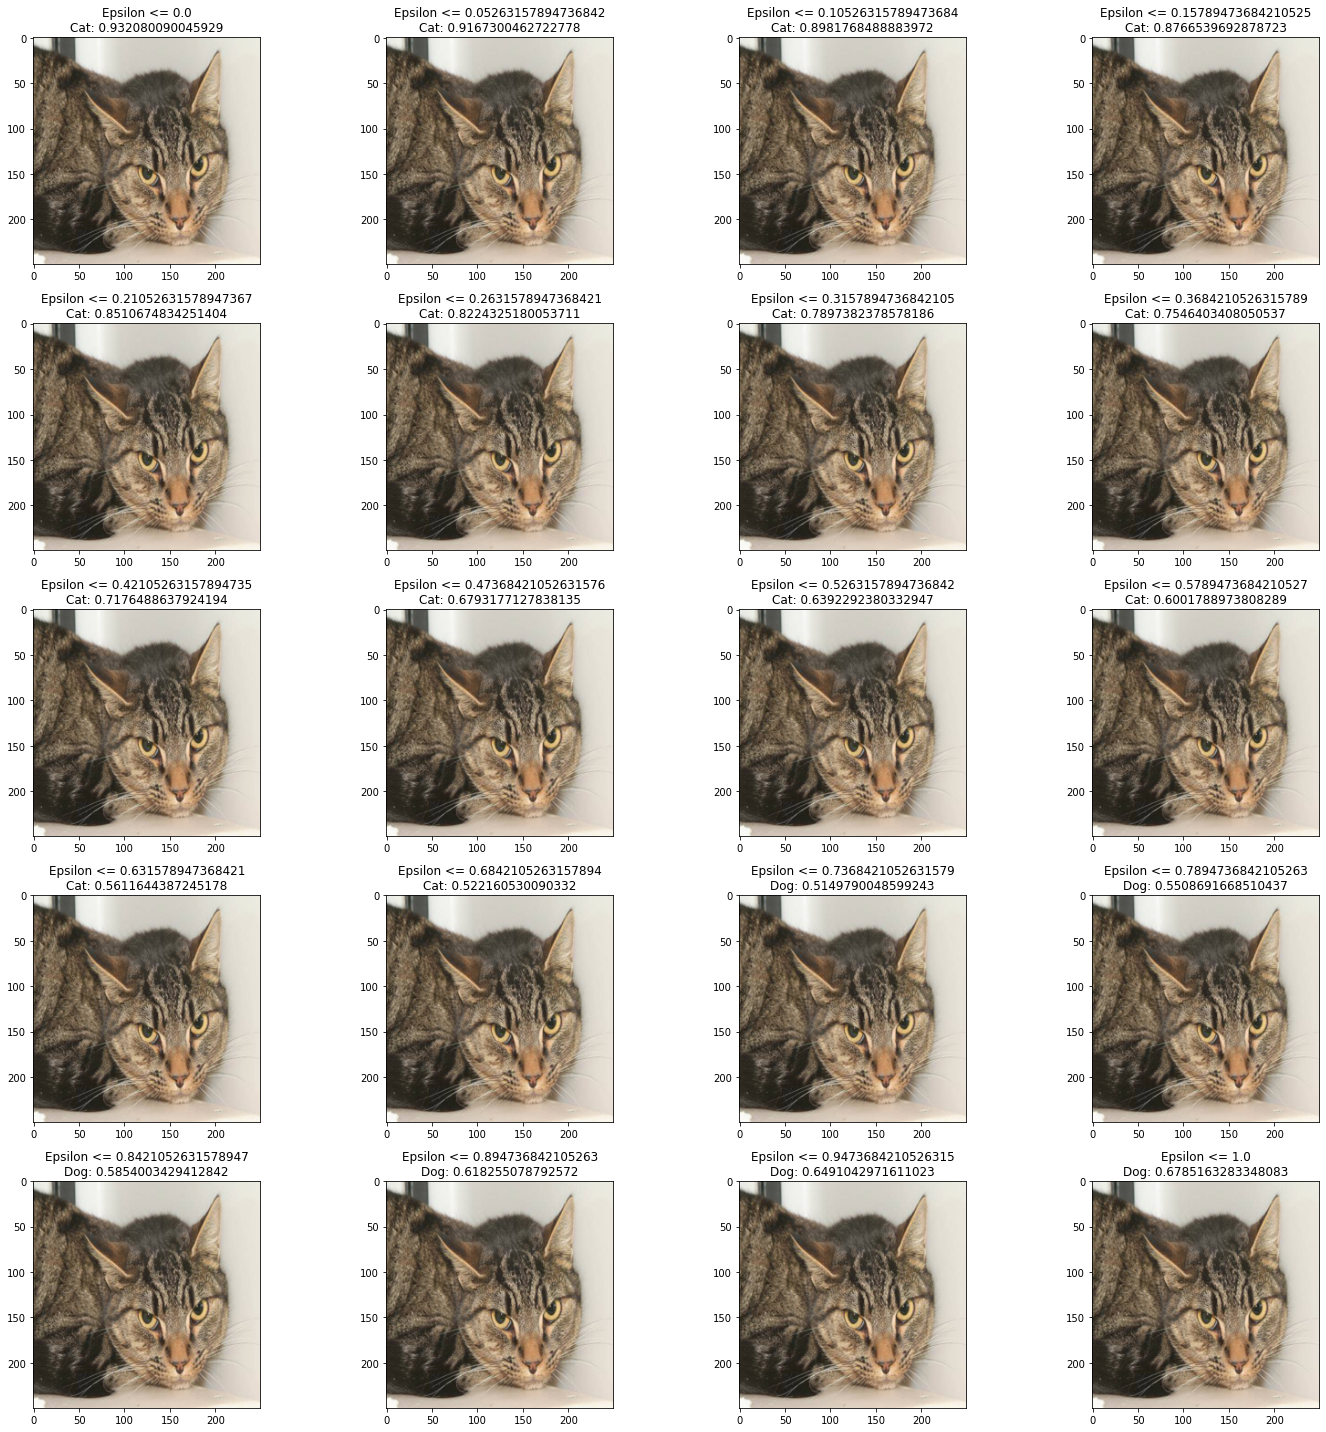

In [ ]:
fig,ax = plt.subplots(5,4,figsize=(20,20))
ax = ax.flatten()
for i in range(len(epsilon)):
  pred = model.predict(np.stack([clipped[i][3]],axis=0))
  label = ""
  if np.argmax(pred,axis=1):
    label = f"Dog: {pred[0,1]}"
  else:
    label = f"Cat: {pred[0,0]}"
  ax[i].imshow(clipped[i][3]);
  ax[i].set_title(f"Epsilon <= {epsilon[i]}\n"+label)
plt.tight_layout()
clear_output(wait=False)
plt.show()

### C&W attack on Inception model

In [ ]:
attack = foolbox.attacks.L2CarliniWagnerAttack()
epsilon = np.linspace(0.0, 1, num=20)
raw, clipped, is_adv = attack(fmodel2 , tf.cast(images_inc,tf.float32), Misclassification(labels_inc), epsilons=epsilon)

epsilons_inc, accuracy_inc = [],[]
for eps, advs_ in zip(np.linspace(0.0, 1, num=20), clipped):
  acc2 = foolbox.utils.accuracy(fmodel2, advs_, labels_inc)
  epsilons_inc.append(eps)
  accuracy_inc.append(acc2)
  print(f"  Epsilon ≤ {eps:.6f}: {acc2 * 100:4.1f} %")
  if acc2 == 0:
      break

  Epsilon ≤ 0.000000: 100.0 %
  Epsilon ≤ 0.052632: 100.0 %
  Epsilon ≤ 0.105263: 100.0 %
  Epsilon ≤ 0.157895: 100.0 %
  Epsilon ≤ 0.210526: 100.0 %
  Epsilon ≤ 0.263158: 100.0 %
  Epsilon ≤ 0.315789: 100.0 %
  Epsilon ≤ 0.368421: 100.0 %
  Epsilon ≤ 0.421053: 100.0 %
  Epsilon ≤ 0.473684: 100.0 %
  Epsilon ≤ 0.526316: 100.0 %
  Epsilon ≤ 0.578947: 100.0 %
  Epsilon ≤ 0.631579: 100.0 %
  Epsilon ≤ 0.684211: 100.0 %
  Epsilon ≤ 0.736842: 100.0 %
  Epsilon ≤ 0.789474: 100.0 %
  Epsilon ≤ 0.842105: 100.0 %
  Epsilon ≤ 0.894737: 100.0 %
  Epsilon ≤ 0.947368: 100.0 %
  Epsilon ≤ 1.000000: 100.0 %


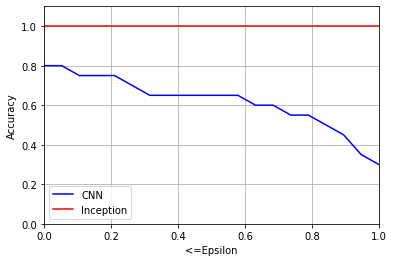

In [ ]:
plt.figure()
plt.plot(epsilons,accuracy,label='CNN',color='blue')
plt.plot(epsilons_inc,accuracy_inc,label='Inception',color='red')

plt.grid()
plt.xlim(0,1)
plt.ylim(0,1.1)
plt.xlabel("<=Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()